In [3]:
import enum
import random

import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np

import copy

In [4]:
# cooperate => True
# defect => False

In [5]:
class TypeOfStrategy(enum.Enum):
    Defactor = 1
    Cooperator = 2
    Tit_for_tat = 3
    Anti_tit_for_tat = 4
    
def chr2strategy(strategy):
    if strategy == 'D':
        return TypeOfStrategy.Defactor
    if strategy == 'C':
        return TypeOfStrategy.Cooperator
    if strategy == 'T':
        return TypeOfStrategy.Tit_for_tat
    if strategy == 'A':
        return TypeOfStrategy.Anti_tit_for_tat
    return None

def strategy2chr(strategy):
    if strategy == TypeOfStrategy.Defactor:
        return 'D'
    if strategy == TypeOfStrategy.Cooperator:
        return 'C'
    if strategy == TypeOfStrategy.Tit_for_tat:
        return 'T'
    if strategy == TypeOfStrategy.Anti_tit_for_tat:
        return 'A'
    return None

In [6]:
# strategija bira uz pomoc next_move koju ce vrednost nas igrac dati (tj. da li ce coop ili defect)
class Strategy:    
    
    def __init__(self, type_of_strategy):
        self.type_of_strategy = type_of_strategy
        self.previous_move = None
        
    def next_move(self):      
        if self.type_of_strategy == TypeOfStrategy.Cooperator:
            return True
        if self.type_of_strategy == TypeOfStrategy.Defactor:
            return False
        if self.type_of_strategy == TypeOfStrategy.Tit_for_tat:
            if self.previous_move == None:
                return True
            return self.previous_move
        if self.type_of_strategy == TypeOfStrategy.Anti_tit_for_tat:
            if self.previous_move == None:
                return False
            return not self.previous_move 
        
    
    def update_previous_move(self, new_move):
        self.previous_move = new_move
        
#         if previous_enemy_move == None:
#             if self.type_of_strategy == TypeOfStrategy.Cooperator or self.type_of_strategy == TypeOfStrategy.Tit_for_tat:
#                 self.previous_move = True
#                 return True
#             else:
#                 self.previous_move = False
#                 return False
#         else:
#             if self.type_of_strategy == TypeOfStrategy.Cooperator:
#                 self.previous_move = True
#                 return True
#             if self.type_of_strategy == TypeOfStrategy.Defactor:
#                 self.previous_move = False
#                 return False
#             if self.type_of_strategy == TypeOfStrategy.Tit_for_tat:
#                 self.previous_move = previous_enemy_move
#                 return previous_enemy_move
#             if self.type_of_strategy == TypeOfStrategy.Anti_tit_for_tat:
#                 self.previous_move = not previous_enemy_move
#                 return not previous_enemy_move
    
    def __str__(self):
        return f"Stg({strategy2chr(self.type_of_strategy)})"

In [7]:
# vrednosti kao rate_of_senescence i max_score su uvek iste, pa neka budu staticke
class Player:
    rate_of_senescence = float('inf')
    maximum_score = 4
    starting_score = 2
    
    mutation_probability = 0.0
    starting_age = 0
    
    def __init__(self, type_of_strategy, i, j):
        self.strategy = Strategy(type_of_strategy)
        self.age = Player.starting_age
        self.score = Player.starting_score
        self.i = i
        self.j = j
     
    def check_death(self):
        chance_death_old_age = (self.age / Player.rate_of_senescence) - 1 
        # ocemo biramo da jedan umre at a time, ili samo ovako?
        if random.random() < chance_death_old_age or self.score <= 0:
            return True
        return False
    
    def reborn(self, neighbours):
        # moguci ishodi:
        # 1) kopira sve od random suseda
        # 2) mutacija => mala verovatnoca, uzima skroz random strategiju, i pocinje ispocetka
        if random.random() < Player.mutation_probability:
            self.mutation()
        else:
            selected_neighbour = random.choice(neighbours)
            self.strategy = Strategy(selected_neighbour.strategy.type_of_strategy)
            #self.strategy.previous_move = selected_neighbour.strategy.previous_move
            self.score = selected_neighbour.score
        self.age = 0
            
    def mutation(self):
        # mala sansa da uzme random strategiju
        self.strategy = Strategy(TypeOfStrategy(random.randint(1, len(TypeOfStrategy))))
        self.age = Player.starting_age        
        self.score = Player.starting_score
        
    def __str__(self):
        return f"Ply({self.strategy}, Age({self.age}), Scr({self.score}))"


In [8]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

In [9]:
class Game:
    Cooperate = True
    Defect = False
    
    def __init__(self, payoff_values, n=10, initial_state=None, num_of_iterations=10, mutation_rate=0.0, rate_of_senescence=float('inf')):
        self.payoff_matrix = self.__set_payoff_matrix(payoff_values)
        self.n = n if initial_state is None else len(initial_state)
        self.state = self.__process_initial_state(n, initial_state)
        self.all_states = []
        self.num_of_iterations = num_of_iterations
        self.strategy_counter = []
        # svaki put kad kreiramo igru, postavljamo staticku vrednost mut_rate za trenutni game (podrazumevano 0)
        Player.mutation_probability = mutation_rate
        Player.rate_of_senescence = rate_of_senescence
     
    def __set_payoff_matrix(self, payoff_values):
        return {
            (Game.Cooperate, Game.Cooperate) : (payoff_values["R"], payoff_values["R"]),
            (Game.Cooperate, Game.Defect) : (payoff_values["S"], payoff_values["T"]),
            (Game.Defect, Game.Cooperate) : (payoff_values["T"], payoff_values["S"]),
            (Game.Defect, Game.Defect) : (payoff_values["P"], payoff_values["P"])
        }
    
    def __process_initial_state(self, n, initial_state):
        state = []
        
        if initial_state is not None:
            state = [[Player(chr2strategy(strategy), i, j) for j, strategy in enumerate(row)] for i, row in enumerate(initial_state)]
        else:
            state = [[Player(TypeOfStrategy(random.randint(1, 4)), i, j) for j in range(n)] for i in range(n)]
        
        return state
    
    def __neighbours(self, i, j):
        neighbours = []
        if i > 0 and j > 0:
            neighbours.append(self.state[i-1][j-1])
        if i > 0:
            neighbours.append(self.state[i-1][j])
        if i > 0 and j < self.n - 1:
            neighbours.append(self.state[i-1][j+1])
        if j > 0:
            neighbours.append(self.state[i][j-1])
        if j < self.n - 1:
            neighbours.append(self.state[i][j+1])
        if i < self.n - 1 and j > 0:
            neighbours.append(self.state[i+1][j-1])
        if i < self.n - 1:
            neighbours.append(self.state[i+1][j])
        if i < self.n - 1 and j < self.n - 1:
            neighbours.append(self.state[i+1][j+1])
        return neighbours
    
    def __select_neighbour_index(self, i, j):
        indices = []
        if i > 0 and j > 0:
            indices.append((i-1, j-1))
        if i > 0:
            indices.append((i-1, j))
        if i > 0 and j < self.n - 1:
            indices.append((i-1, j+1))
        if j > 0:
            indices.append((i, j-1))
        if j < self.n - 1:
            indices.append((i, j+1))
        if i < self.n - 1 and j > 0:
            indices.append((i+1, j-1))
        if i < self.n - 1:
            indices.append((i+1, j))
        if i < self.n - 1 and j < self.n - 1:
            indices.append((i+1, j+1))
            
        index = random.randint(0, len(indices) - 1)
        
        return indices[index]
    
    def __players_interations(self, player1, player2, neighbours1, neighbours2):
        p1_move = player1.strategy.next_move()
        p2_move = player2.strategy.next_move() 
        player1.strategy.previous_move = p2_move
        player2.strategy.previous_move = p1_move 
        #print(f'Moves: {p1_move}, {p2_move}')
        p1_payoff_value, p2_payoff_value = self.payoff_matrix[(p1_move, p2_move)]
    
        #print(f'Payoff: {p1_payoff_value}, {p2_payoff_value}')
        player1.score = min(Player.maximum_score,  player1.score + p1_payoff_value)
        player2.score = min(Player.maximum_score,  player2.score + p2_payoff_value)
    
        if player1.check_death():
            player1.reborn(neighbours1)
        if player2.check_death():
            player2.reborn(neighbours2)
    
    def play_game(self):
        
        for iteration in range(self.num_of_iterations):
            #print(f"Iterations #: {iteration + 1}")
            self.all_states.append(copy.deepcopy(self.state))
            
            #self.print_strategy_matrix()
            #self.print_score_matrix()
            #self.print_age_matrix()
            
            self.strategy_counter.append(
                {
                    TypeOfStrategy.Cooperator: self.count_stategy(TypeOfStrategy.Cooperator), 
                    TypeOfStrategy.Defactor: self.count_stategy(TypeOfStrategy.Defactor),
                    TypeOfStrategy.Tit_for_tat: self.count_stategy(TypeOfStrategy.Tit_for_tat),
                    TypeOfStrategy.Anti_tit_for_tat: self.count_stategy(TypeOfStrategy.Anti_tit_for_tat)
                }
            )
            
            #print(self.strategy_counter[-1])
                                          
            # Update game
            for i in range(self.n):
                for j in range(self.n):
                    #print(f'Player: {i}, {j}')
                    player1 = self.state[i][j]
                    neighbours1 = self.__neighbours(i, j)
                    
                    (neighbour_i, neighbour_j) = self.__select_neighbour_index(i, j)
                    player2 = self.state[neighbour_i][neighbour_j]
                    neighbours2 = self.__neighbours(neighbour_i, neighbour_j)
                    
                    self.__players_interations(player1, player2, neighbours1, neighbours2)
                    player1.age += 1
                    
        return 
    
    def num_of_players(self):
        return self.n * self.n
                    
    def count_stategy(self, target_strategy):
        return [strategy for row in self.strategy_matrix() for strategy in row].count(target_strategy)
    
    def strategy_matrix(self):
        return [[player.strategy.type_of_strategy for player in row] for row in self.state]
    
    def print_strategy_matrix(self):
        print("\n".join([" ".join([strategy2chr(player.strategy.type_of_strategy) for player in row]) for row in self.state]))
        
    def print_strategy_matrix_at_instance(self, iteration):
        print("\n".join([" ".join([strategy2chr(player.strategy.type_of_strategy) for player in row]) for row in self.all_states[iteration - 1]]))

    def strategy_matrix_at_instance(self, iteration):
        return [[player.strategy.type_of_strategy for player in row] for row in self.all_states[iteration - 1]]        
    
    def age_matrix(self):
        return [[player.age for player in row] for row in self.state]
    
    def print_age_matrix(self):
        print("\n".join([" ".join([f'{player.age:2}' for player in row]) for row in self.state]))
    
    def score_matrix(self):
        return [[player.score for player in row] for row in self.state]
        
    def print_score_matrix(self):
        print("\n".join([" ".join([f'{player.score:2}' for player in row]) for row in self.state]))
        
    def __str__(self):
        return "\n".join(["; ".join([str(player) for player in row]) for row in self.state])
    


In [10]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

initial_state = [
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'T', 'T', 'T', 'D'],
    ['D', 'D', 'D', 'T', 'T', 'T', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'T', 'T', 'T', 'D', 'D'],
    ['D', 'D', 'T', 'T', 'T', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D']
]

game = Game(payoff_values, n=7, initial_state=initial_state, num_of_iterations=50)
game.play_game()

print("Final State:")
print("Strategies:")
game.print_strategy_matrix()
print("Ages:")
game.print_age_matrix()
print("Score:")
game.print_score_matrix()

Final State:
Strategies:
D D D D D D D
D D D T T T D
D D D T T T D
D D D D D D D
D D T T T D D
D D T T T D D
D D D D D D D
Ages:
50 50 50 50 50 50 50
50 50 50 50 50 50 50
50 50 50 50 50 50 50
50 50 50 50 50 50 50
50 50 50 50 50 50 50
50 50 50 50 50 50 50
50 50 50 50 50 50 50
Score:
 2  2  2  2  4  4  2
 2  2  2  2  2  1  2
 2  2  4  1  1  2  2
 2  4  2  4  4  4  2
 2  2  2  1  1  2  2
 2  2  1  1  1  2  2
 2  2  2  4  4  2  2


# Slučajevi bez mutacije

## Distribucija strategija

1. Sve četri strategija
2. DEF vs COOP
3. DEF vs TFT
4. DEF vs ATFT
5. COOP vs TFT
6. COOP vs ATFT
7. TFT vs ATFT

In [11]:
def plot_strategy_ratio(game, num_rows, num_cols, pos, title):
    
    X = np.linspace(0, game.num_of_iterations, num=game.num_of_iterations)
    
    coop_count = np.array([count[TypeOfStrategy.Cooperator] / game.num_of_players() for count in game.strategy_counter])
    def_count = np.array([count[TypeOfStrategy.Defactor] / game.num_of_players() for count in game.strategy_counter])
    tft_count = np.array([count[TypeOfStrategy.Tit_for_tat] / game.num_of_players() for count in game.strategy_counter])
    atft_count = np.array([count[TypeOfStrategy.Anti_tit_for_tat] / game.num_of_players() for count in game.strategy_counter])

    Y1 = np.ones(game.num_of_iterations)
    Y2 = coop_count + def_count + tft_count
    Y3 = def_count + tft_count
    Y4 = tft_count
    Y5 = np.zeros(game.num_of_iterations)
    
    plt.subplot(num_rows, num_cols, pos)
    
    plt.plot(X, Y1, color='white')
    plt.fill_between(X, Y1, color='yellow', label='ATFT')
    plt.plot(X, Y2, color='white')
    plt.fill_between(X, Y2, color='blue', label='COOP')
    plt.plot(X, Y3, color='white')
    plt.fill_between(X, Y3, color='red', label='DEF')
    plt.plot(X, Y4, color='white')
    plt.fill_between(X, Y4, color='green', label='TFT')
    plt.plot(X, Y5, color='white')
    
    plt.legend(loc='lower left')
    plt.title(title)

    

### Inicijalizacija početnih parametara

In [12]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

initial_state_1 =[
    ['x' for _ in range(10)]
    for _ in range(10)
]

for i in range(10):
    for j in range(10):
        prob = random.random()
        if prob < 0.25:
            initial_state_1[i][j] = 'C'
        elif prob < 0.5:
            initial_state_1[i][j] = 'D'
        elif prob < 0.75:
            initial_state_1[i][j] = 'T'
        else:
            initial_state_1[i][j] = 'A'
                
initial_state_2 = [
    ['D' if random.random() < 0.5 else 'C' for _ in range(10)]
    for _ in range(10)
]

initial_state_3 = [
    ['D' if random.random() < 0.5 else 'T' for _ in range(10)]
    for _ in range(10)
]

initial_state_4 = [
    ['D' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

initial_state_5 = [
    ['C' if random.random() < 0.5 else 'T' for _ in range(10)]
    for _ in range(10)
]

initial_state_6 = [
    ['C' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

initial_state_7 = [
    ['T' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

### Pokretanje igara

In [13]:
# nismo slali mutation_rate i rate_of_senescence, jer su podrazumevani da ih nema!

game_1 = Game(payoff_values, n=10, initial_state=initial_state_1, num_of_iterations=100)
game_1.play_game()

game_2 = Game(payoff_values, n=10, initial_state=initial_state_2, num_of_iterations=100)
game_2.play_game()

game_3 = Game(payoff_values, n=10, initial_state=initial_state_3, num_of_iterations=100)
game_3.play_game()

game_4 = Game(payoff_values, n=10, initial_state=initial_state_4, num_of_iterations=100)
game_4.play_game()

game_5 = Game(payoff_values, n=10, initial_state=initial_state_5, num_of_iterations=100)
game_5.play_game()

game_6 = Game(payoff_values, n=10, initial_state=initial_state_6, num_of_iterations=100)
game_6.play_game()

game_7 = Game(payoff_values, n=10, initial_state=initial_state_7, num_of_iterations=100)
game_7.play_game()

### Plotovanje distribucija strategija kroz iteracije

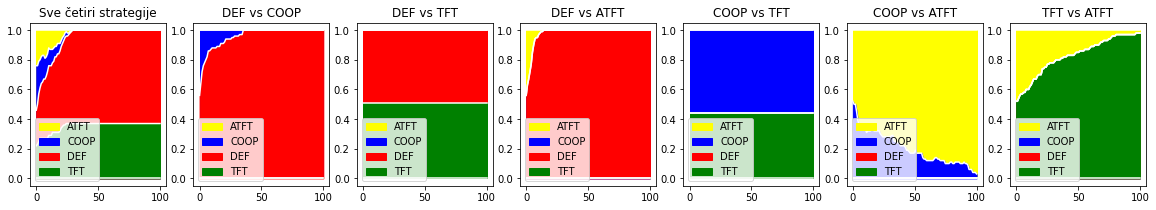

In [14]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(3)
plot_strategy_ratio(game_1, 1, 7, 1, 'Sve četiri strategije')
plot_strategy_ratio(game_2, 1, 7, 2, 'DEF vs COOP')
plot_strategy_ratio(game_3, 1, 7, 3, 'DEF vs TFT')
plot_strategy_ratio(game_4, 1, 7, 4, 'DEF vs ATFT')
plot_strategy_ratio(game_5, 1, 7, 5, 'COOP vs TFT')
plot_strategy_ratio(game_6, 1, 7, 6, 'COOP vs ATFT')
plot_strategy_ratio(game_7, 1, 7, 7, 'TFT vs ATFT')
plt.show()

In [15]:
# u game stavljamo mutation, i on salje player-u
# uradimo caseove
# svaki player i, j => mozda player ima i broj iteracije?
# istrazivanje kako tacno rade fje

In [16]:
def plot_strategy_matrix(game, iteration):
    strategy_matrix = game.strategy_matrix_at_instance(iteration)
    
    n = len(strategy_matrix)
    
    data = np.zeros(shape=(n, n))
    
    for i in range(n):
        for j in range(n):
            if strategy_matrix[i][j] == TypeOfStrategy.Cooperator:
                data[i][j] = 2
            elif strategy_matrix[i][j] == TypeOfStrategy.Defactor:
                data[i][j] = 7
            elif strategy_matrix[i][j] == TypeOfStrategy.Tit_for_tat:
                data[i][j] = 12
            elif strategy_matrix[i][j] == TypeOfStrategy.Anti_tit_for_tat:
                data[i][j] = 17
    
    cmap = colors.ListedColormap(['blue', 'red', 'green', 'yellow'])
    bounds = [0, 5, 10, 15, 20]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots()
    
    ax.set_title(f'Stanje u iteraciji {iteration}')
    ax.imshow(data, cmap=cmap, norm=norm)
    
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, n, 1))
    ax.set_yticks(np.arange(-0.5, n, 1))
        
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    plt.show()

In [17]:
import gudhi

In [18]:
def barcode_generator(game_strategy_matrix, wanted_strategy):
    point_cloud = []
    n = len(game_strategy_matrix)
    for i in range(n):
        for j in range(n):
            if game_strategy_matrix[i][j] == wanted_strategy:
                point_cloud.append([i + 1, j + 1])
   
    rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=n * n)
    simplex_tree  = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    
    gudhi.plot_persistence_barcode(diag)
    plt.show()    

In [19]:
# provera da li lepo iscrtava na primeru datom u tekstu

In [20]:
initial_state_case_1 = [
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'D', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'D', 'D', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'D', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
]

game_case_1 = Game(payoff_values, n=10, initial_state=initial_state_case_1, num_of_iterations=25)
game_case_1.play_game()

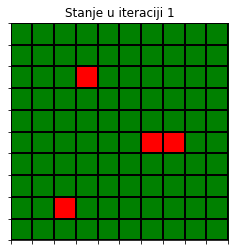

In [21]:
# ispisuje prvu iteraciju! (iteracije pocinju od 1!)
plot_strategy_matrix(game_case_1, 1) 

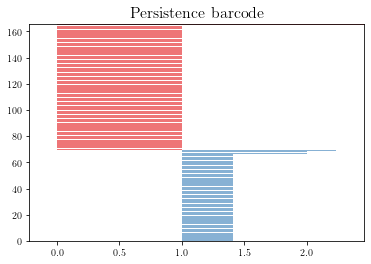

In [22]:
barcode_generator(game_case_1.strategy_matrix_at_instance(1), TypeOfStrategy.Tit_for_tat)

## Case (1) 
##### No mutation, no death of old age

In [23]:
initial_state_case_1 = [
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['D', 'D', 'D', 'D', 'T', 'T', 'T'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
]

game_case_1 = Game(payoff_values, n=7, initial_state=initial_state_case_1, num_of_iterations=25)
game_case_1.play_game()

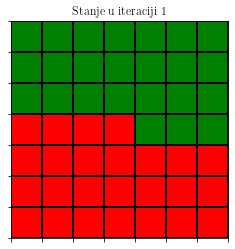

In [24]:
# ispisuje prvu iteraciju! (iteracije pocinju od 1!)
plot_strategy_matrix(game_case_1, 1) 

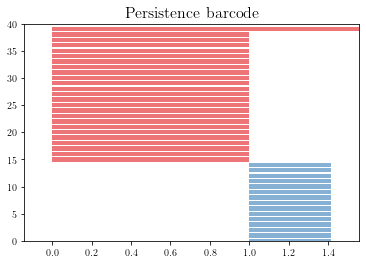

In [25]:
barcode_generator(game_case_1.strategy_matrix_at_instance(1), TypeOfStrategy.Defactor)

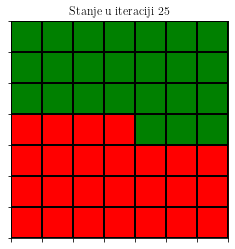

In [26]:
plot_strategy_matrix(game_case_1, 25) 

#### Imamo zamrznuto stanje => nista se ne menja vremenom

## Case (2) 
##### No mutation, no death of old age

In [27]:
initial_state_case_2 = [
    [ 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    [ 'D', 'D', 'D', 'T', 'T', 'T', 'D'],
    [ 'D', 'D', 'D', 'T', 'T', 'T', 'D'],
    [ 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    [ 'D', 'T', 'T', 'T', 'D', 'D', 'D'],
    [ 'D', 'T', 'T', 'T', 'D', 'D', 'D'],
    [ 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
]

game_case_2 = Game(payoff_values, n=7, initial_state=initial_state_case_2, num_of_iterations=1000)
game_case_2.play_game()

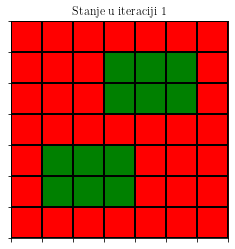

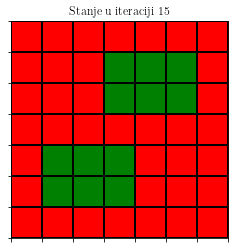

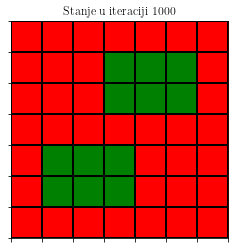

In [28]:
plot_strategy_matrix(game_case_2, 1)
plot_strategy_matrix(game_case_2, 15)
plot_strategy_matrix(game_case_2, 1000)

In [29]:
game_case_2.score_matrix()

[[2, 2, 4, 2, 2, 2, 2],
 [2, 2, 4, 2, 1, 1, 4],
 [2, 2, 2, 1, 2, 1, 2],
 [2, 4, 2, 4, 4, 2, 2],
 [4, 2, 1, 1, 2, 2, 2],
 [2, 2, 1, 1, 2, 2, 2],
 [2, 4, 2, 4, 2, 2, 2]]

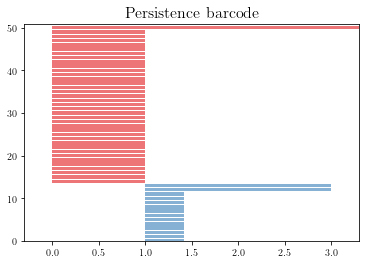

In [30]:
barcode_generator(game_case_2.strategy_matrix_at_instance(15), TypeOfStrategy.Defactor)

##  With mutation, and death of old age

In [31]:
random.seed(42)

In [32]:
initial_state_case_3 =[
    ['A', 'A', 'A', 'A', 'A', 'A', 'A'],
    ['A', 'A', 'A', 'A', 'A', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'C', 'C', 'C', 'C', 'C', 'C'],
    ['C', 'C', 'C', 'C', 'C', 'C', 'C'],
]

# for i in range(7):
#     for j in range(7):
#         prob = random.random()
#         if prob < 0.25:
#             initial_state_case_3[i][j] = 'C'
#         elif prob < 0.5:
#             initial_state_case_3[i][j] = 'D'
#         elif prob < 0.75:
#             initial_state_case_3[i][j] = 'T'
#         else:
#             initial_state_case_3[i][j] = 'A'
            
game_case_3 = Game(payoff_values, n=7, initial_state=None, num_of_iterations=1000, mutation_rate=0.05, rate_of_senescence=20)
game_case_3.play_game()

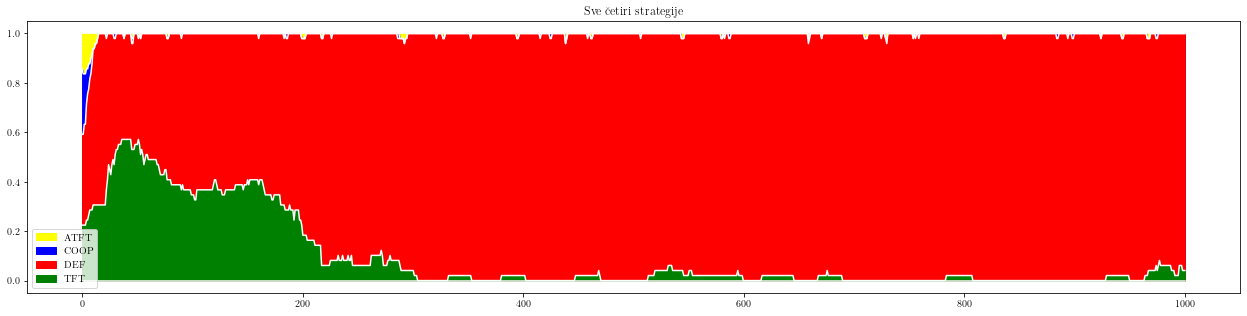

In [33]:
fig = plt.figure()
fig.set_figwidth(100)
fig.set_figheight(5)
plot_strategy_ratio(game_case_3, 1, 4, 1, 'Sve četiri strategije')
plt.show()

In [34]:
def barcode_generator_over(game, start_iter, end_iter, wanted_strategy):
    point_cloud = []
    
    n = len(game.strategy_matrix_at_instance(1))
    for iteration in range(start_iter, end_iter + 1):
        game_strategy_matrix = game.strategy_matrix_at_instance(iteration)
        for i in range(n):
            for j in range(n):
                if game_strategy_matrix[i][j] == wanted_strategy:
                    point_cloud.append([i + 1, j + 1, iteration])
    
    print("heheh")
    rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=n * n * (end_iter - start_iter))
    simplex_tree  = rips_complex.create_simplex_tree(max_dimension=3)
    diag = simplex_tree.persistence()
    
    gudhi.plot_persistence_barcode(diag)
    plt.show()  

## Case (4)

In [ ]:
for i in range(727, 733):
    plot_strategy_matrix(game_case_3, i)

heheh


## Case (3 + 5)

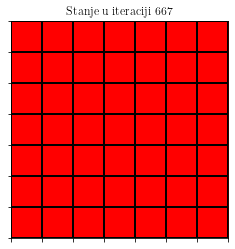

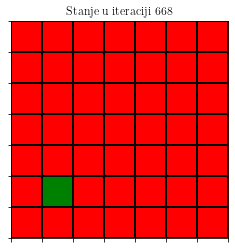

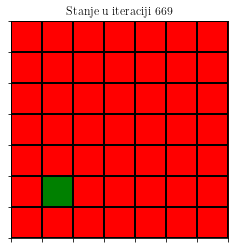

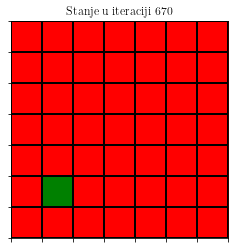

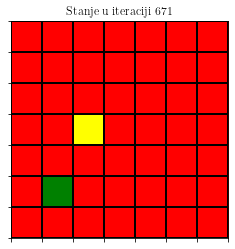

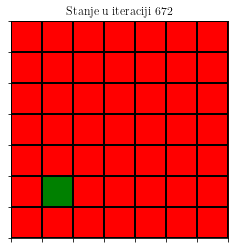

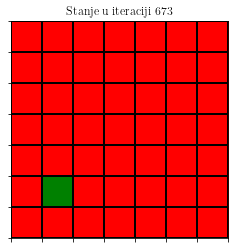

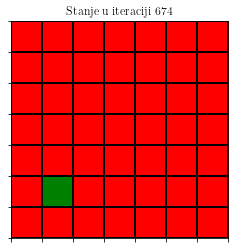

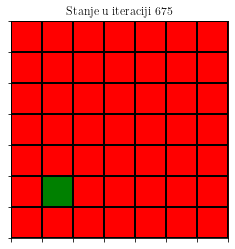

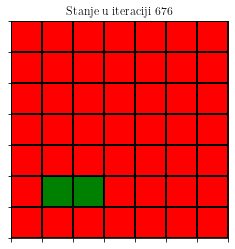

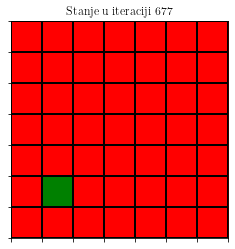

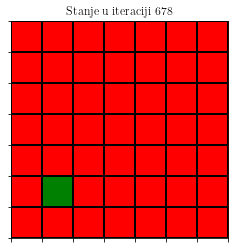

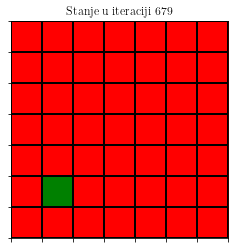

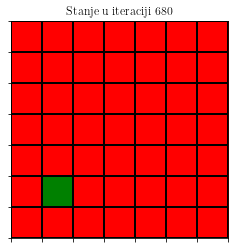

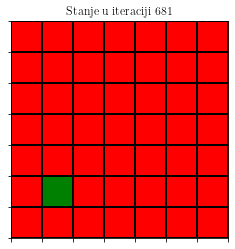

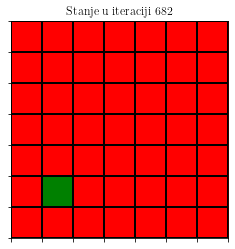

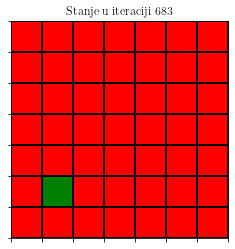

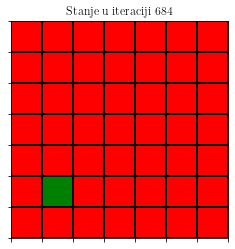

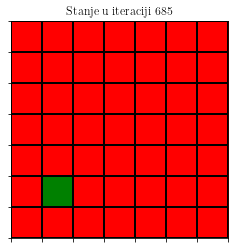

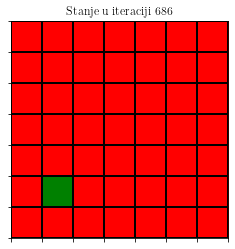

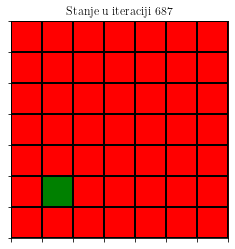

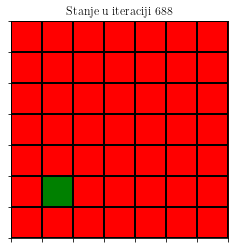

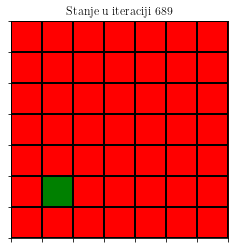

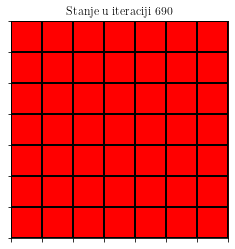

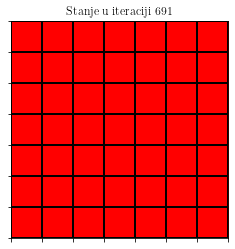

In [56]:
for i in range(667, 692):
    plot_strategy_matrix(game_case_3, i)